In [1]:
%matplotlib inline

from io import BytesIO
from base64 import b64encode

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import numpy as np

import scipy.signal as sps

from time import time

from IPython.display import HTML
import IPython.display 
from PIL import Image

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 32, 24

# Draws a uint16 image as a uint8, defaults to one frame
def drawdata(bm, x = 844, y = 505, hscale = 1, vscale = 1, outsize = None):
#    bmf = np.float32(bm) / 65536.0
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
#    imshow(np.asarray(im))
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())
                         
#drawdata(data)                         

# This follows the default scale in lddecodercuda
minire = -60
maxire = 140

hz_ire_scale = (9300000 - 8100000) / 100
minn = 8100000 + (hz_ire_scale * -60)

out_scale = 65534.0 / (maxire - minire)

in_scale = out_scale
in_minire = -60

def RawToIRE(data):
    return (np.float32(data) / in_scale) + in_minire

def IREToRaw(data):
    return np.uint16((data - minire) * out_scale)

def cfoutput_torgb(output):
    r = output[3].reshape((505, 844))
    g = output[4].reshape((505, 844))
    b = output[5].reshape((505, 844))

    rgbArray = np.zeros((505,844,3), 'uint8')
    rgbArray[...,0] = np.clip(r, 0, 100) * 2.55
    rgbArray[...,1] = np.clip(g, 0, 100) * 2.55
    rgbArray[...,2] = np.clip(b, 0, 100) * 2.55

    im = Image.fromarray(rgbArray)
    im = im.resize((844, 505))

    #    imshow(np.asarray(im))

    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())

import tensorflow as tf

In [17]:
t0 = time()

ntscimg_shape = [1, 505, 844, 1]

def conv1d(data, b, _padding='SAME'):
    #tf_var = tf.Variable(np.array(b).reshape(1, len(b), 1, 1), dtype=tf.float32)
    #tf_var.initializer.run()

    return tf.nn.conv2d(data, b, strides=[1,1,1,1], padding=_padding)

# carry out phase inversion based off predefined stitches
def phaseinvert(c, stitches1, stitches2):
    csplit = tf.dynamic_partition(c, partition, 2)
    csplit[1] *= -1 
    return tf.reshape(tf.dynamic_stitch([stitches1, stitches2], csplit), ntscimg_shape)

# Used to put I+Q back together to remove C from Y, and to double IQ for output by repeating data1
def InterleaveX(data1, data2):
    wide_pre = tf.dynamic_stitch([stitchIQ[0], stitchIQ[1]], [tf.transpose(data1), tf.transpose(data2)])
    return tf.reshape(tf.transpose(wide_pre), ntscimg_shape)

def buildmasks():
    # Create I and Q mask images
    IQmask_p = np.zeros((505, 844), dtype=np.float32)

    for i in range(0, 844, 4):
        # We can transpose the array and set all values of a column at once
        IQmask_p.T[i + 0] = 1
        IQmask_p.T[i + 1] = -1
        IQmask_p.T[i + 2] = -1
        IQmask_p.T[i + 3] = 1

    IQmask = tf.Variable(IQmask_p.reshape(ntscimg_shape), dtype=tf.float32)
    IQmask.initializer.run()

    partIQp = np.zeros((844), dtype=np.int32)

    for i in range(0, 844, 2):
        # We can transpose the array and set all values of a column at once
        partIQp[i] = 0
        partIQp[i + 1] = 1

    partIQ = tf.Variable(partIQp.reshape([1, 844]), dtype=tf.int32)
    partIQ.initializer.run()
    
    stitchIQ = []
    for i in [0, 1]:
        stitchp = np.where(partIQp == i)[0]

        stitchIQ.append(tf.Variable(stitchp.reshape([1, 422]), dtype=tf.int32))
        stitchIQ[-1].initializer.run()

    return IQmask, partIQ, stitchIQ

# Variables useful for comb filtering/YC splitting
def buildfilters():
    
    shiftup = np.zeros((505), dtype=np.int32)
    shiftup[0:503] = range(2, 505)

    shiftdown = np.zeros((505), dtype=np.int32)
    shiftdown[2:505] = range(0, 503)
    
    fsc = 315.0 / 88.0
    ChromaLPFp = sps.firwin(17, [1.5 / fsc])
    ChromaLPF = tf.Variable(ChromaLPFp.reshape(1, 17, 1, 1), dtype=np.float32)
    ChromaLPF.initializer.run()

    YC_LPF = tf.Variable(np.array([.5,-1,.5]).reshape(1, 3, 1, 1), dtype=np.float32)
    YC_LPF.initializer.run()

    return shiftup, shiftdown, ChromaLPF, YC_LPF

# Colorspace conversion
def YIQtoRGB(Y, I, Q):
    R = Y + ( .956 * I) + (.621 * Q)
    G = Y - ( .272 * I) - (.647 * Q)
    B = Y - (1.106 * I) + (1.703 * Q)

    return R, G, B

# rough YC split, with level inversions so I and Q have locked phase
def YCsplit(x):
    YC_LPF = tf.Variable(np.array([.5,-1,.5]).reshape(1, 3, 1, 1), dtype=np.float32)
    YC_LPF.initializer.run()

    c_fixedlevels = phaseinvert(conv1d(x, YC_LPF), stitches1, stitches2) * IQmask

    # break out I and Q - note that horizontal splits seem to require transposition!
    c_fixedlevelsT = tf.transpose(c_fixedlevels)
    partedIQ = tf.dynamic_partition(c_fixedlevelsT, partIQ, 2)

    # detranspose the split IQ data and shape into half-width image
    Q = tf.reshape(tf.transpose(partedIQ[0]), [1, 505, 422, 1])
    I = tf.reshape(tf.transpose(partedIQ[1]), [1, 505, 422, 1])
    
    return I, Q

def proc2DCF(data):
    up = tf.reshape(tf.gather(tf.reshape(data, [505, 422, 1]), shiftup), [1, 505, 422, 1])
    down = tf.reshape(tf.gather(tf.reshape(data, [505, 422, 1]), shiftdown), [1, 505, 422, 1])
    sum2 = tf.abs((data - up) + (data - down))

    return data * tf.clip_by_value((1 - (sum2 / 100)), 0, 1)

rgbArray = []

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=.2)
with tf.Session(config=tf.ConfigProto(log_device_placement=True, gpu_options=gpu_options)) as sess:
    x = tf.placeholder(tf.float32, ntscimg_shape)
    partition = tf.placeholder(tf.int32, [1, 505])
    stitches1 = tf.placeholder(tf.int32)
    stitches2 = tf.placeholder(tf.int32)
    RGBout = tf.placeholder(tf.uint8, [505, 844, 3])

    # These need to be done inside the session
    IQmask, partIQ, stitchIQ = buildmasks()
    shiftup, shiftdown, ChromaLPF, YC_LPF = buildfilters()

    # Get a rough Y/C split
    I, Q = YCsplit(x)
    
    # Chroma bandwidth filtering
    I, Q = conv1d(I, ChromaLPF), conv1d(Q, ChromaLPF)
    
    # Prep 1D Y
    C_1D = InterleaveX(Q, I) # re-merge I+Q
    C_1DforY = phaseinvert(C_1D * IQmask, stitches1, stitches2) # re-invert phase and levels to match C-in-Y
    Y1D = x + C_1DforY
    

    # perform crude 2D CF
    I, Q = proc2DCF(I), proc2DCF(Q)

    # Wrapup phase

    C_afterproc = InterleaveX(Q, I) # re-merge I+Q
    c_fory = phaseinvert(C_afterproc * IQmask, stitches1, stitches2) # re-invert phase and levels to match C-in-Y

    # Compute final Y
    Y = x + c_fory

    # Double I and Q width 
    Iwide, Qwide = InterleaveX(I, I), InterleaveX(Q, Q)
    
    Yclip = tf.image.crop_to_bounding_box(tf.reshape(Y, (505, 844, 1)), 24, 80, 480, 744)
    Iclip = tf.image.crop_to_bounding_box(tf.reshape(Iwide, (505, 844, 1)), 24, 80, 480, 744)
    Qclip = tf.image.crop_to_bounding_box(tf.reshape(Qwide, (505, 844, 1)), 24, 80, 480, 744)
    
    R, G, B = YIQtoRGB(Yclip, Iclip, Qclip)
    
    # 'front end' begins here
    
    infd = open('/home/cpage/ld-decode/he010-lobster.tbc', 'rb')
    outfd = open('testout.rgb', 'wb')
    
    rgbArray = np.zeros((480,744,3), 'uint8')

    t1 = time()
    
    while True:
        try:
            indata = infd.read((844 * 505 * 2))
        except:
            indata = None
            
        if indata is None or len(indata) < (844 * 505 * 2):
            break
            
        data = np.fromstring(indata, 'uint16', len(indata)//2)

        rowphase = data[:505*844].reshape(505,844)[:,0] == 32768
        data1 = RawToIRE(data[:505*844])

        in_partition = np.int32(rowphase).reshape(1,505)
        in_stitches1 = np.where(in_partition == 0)[1]
        in_stitches2 = np.where(in_partition == 1)[1]

        #out_picture = np.zeros((505, 844, 3), dtype=np.uint8)

        output = sess.run([Y, Iwide, Qwide, R, G, B, Yclip], feed_dict={x: data1.T.reshape(1,505,844,1), 
                                                              partition: in_partition,
                                                              stitches1: in_stitches1,
                                                              stitches2: in_stitches2})
        
        Rout = output[3].reshape((480, 744))
        Gout = output[4].reshape((480, 744))
        Bout = output[5].reshape((480, 744))

        rgbArray[...,0] = np.clip(Rout, 0, 100) * 2.55
        rgbArray[...,1] = np.clip(Gout, 0, 100) * 2.55
        rgbArray[...,2] = np.clip(Bout, 0, 100) * 2.55
        
        #outfd.write(rgbArray.reshape(844 * 505 * 3))
        
        break
        
t2 = time()
print(t2 - t1, t1 - t0)

0.3002026081085205 1.2318875789642334


(357120,)
uint8 (480, 744) (480, 744)


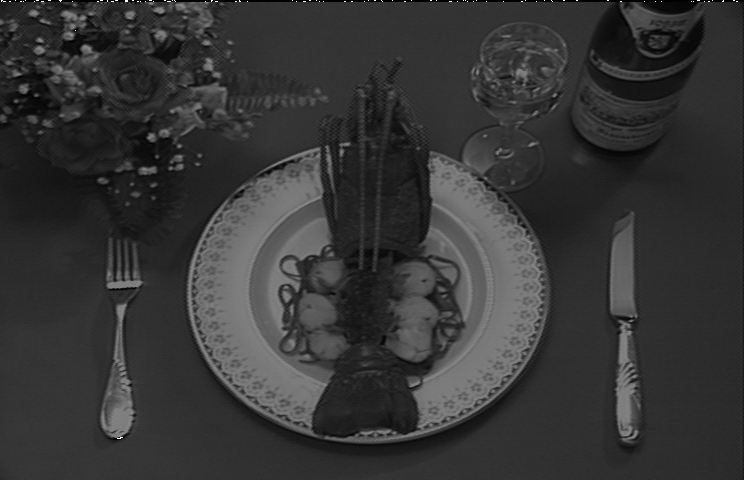

In [14]:
output[-1].shape
drawdata(output[-1].reshape(744*480) * 300, 744, 480)

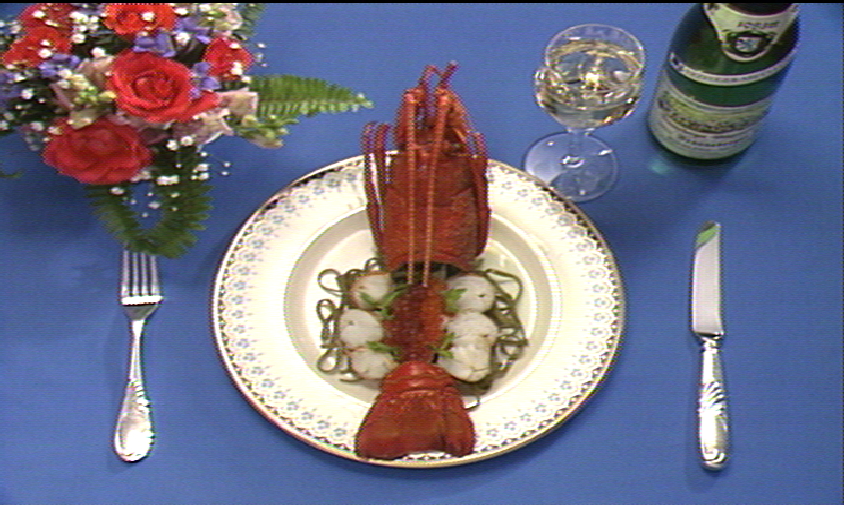

In [18]:
def drawImage(rgb):
    im = Image.fromarray(rgb)
    im = im.resize((844, 505))

    #    imshow(np.asarray(im))

    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())

drawImage(rgbArray)

In [14]:
with open('testout.rgb', 'wb') as fd:
    for i in rgbArray:
        fd.write(i.reshape(844*505*3))